In [22]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from scipy import stats

import math

from datetime import datetime

pd.set_option('display.max_rows', 500)

### Read Data

In [2]:
data_5min_ta = pd.read_csv('data_5min_ta.csv',index_col=0)

In [3]:
data_5min_ta.index = pd.to_datetime(data_5min_ta.index)

### Treating Null Values in the data

In [4]:
data_5min_ta.isnull().sum()

open                              0
close                             0
high                              0
low                               0
volume                            0
nextClosingPrice                  0
volume_adi                        0
volume_obv                        0
volume_cmf                        0
volume_fi                        13
volume_em                         1
volume_sma_em                     1
volume_vpt                        0
volume_nvi                        0
volatility_atr                    0
volatility_bbm                    0
volatility_bbh                    0
volatility_bbl                    0
volatility_bbw                    0
volatility_bbp                    1
volatility_bbhi                   0
volatility_bbli                   0
volatility_kcc                    0
volatility_kch                    0
volatility_kcl                    0
volatility_kchi                   0
volatility_kcli                   0
volatility_dcl              

##### Observations

Row Drops  
1) volume_fi - first 13 rows null. So, drop these rows  
2) volume_em - first row null. So, drop this row  
3) volume_sma_em - first row null. So, drop this row  
4) volatility_bbp - first row null. So, drop this row  
5) trend_macd - first 25 rows null. So, drop these rows  
6) trend_macd_signal - first 33 rows null. So, drop these rows  
7) trend_macd_diff - first 33 rows null. So, drop these rows  
8) trend_ema_fast - first 11 rows null. So, drop these rows  
9) trend_ema_slow - first 25 rows null. So, drop these rows  
10) trend_trix - first 43 rows null. So, drop these rows  
11) trend_cci - first row null. So, drop this row  
12) momentum_tsi - first row null. So, drop this row  
13) momentum_kama - first 9 rows null. So, drop these rows  
14) momentum_roc - first 12 rows null. So, drop these rows  
15) others_dlr - first row null. So, drop this row  
  
Column Drops  
1) trend_vortex_ind_pos - Has discontinuous na values, so drop this feature  
2) trend_vortex_ind_neg - Has discontinuous na values, so drop this feature  
3) trend_vortex_ind_diff - Has discontinuous na values, so drop this feature  
4) momentum_mfi - many null values, so drop this feature  
5) momentum_uo - Has discontinuous na values, so drop this feature  
6) momentum_stoch - Has discontinuous na values, so drop this feature  
7) momentum_stoch_signal - Has discontinuous na values, so drop this feature  
8) momentum_wr - Has discontinuous na values, so drop this feature  
9) trend_psar_up - many null values, so drop this feature  
10) trend_psar_down - many null values, so drop this feature  

#### Drop unwanted features (Column drops)

In [9]:
col_drops = ['trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'momentum_mfi', 'momentum_uo', 
 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'trend_psar_up', 'trend_psar_down']
data_5min_ta = data_5min_ta.drop(col_drops, axis=1)

#### Drop unwanted rows (Row drops)

In [14]:
data_5min_ta = data_5min_ta.dropna(subset=['trend_trix'])

#### There are no null rows now!

In [16]:
data_5min_ta.isnull().sum().sum()

0

### Modelling

In [17]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

In [23]:
def testModel(df, windowLength, startingIndex, endingIndex, stepSize, modelName):

    # lists to store data, will concat to make result data frame
    rmseList = []
    predList = []
    realList = []
    predTimeList = []
    
    # extract feature and test data
    X = df.drop(['nextClosingPrice'], axis=1)
    y = df['nextClosingPrice']

    # rolling window test
    for i in range(startingIndex, endingIndex, stepSize):
        
        # split the data
        X_train, X_test = X[i-windowLength:i], X[i:i+1]
        y_train, y_test = y[i-windowLength:i], y[i]
        
        # create a new model
        if modelName == 'dt':
            model = DecisionTreeRegressor()
        elif modelName == 'xgb':
            model = XGBRegressor()
        elif modelName == 'lgbm':
            model = LGBMRegressor()
        elif modelName == 'lr':
            model = LinearRegression()
        elif modelName == 'ridge':
            model = Ridge(alpha=0.01)
        elif modelName == 'svr':
            model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
        
        # train the model
        model.fit(X_train, y_train)

        # make a prediction
        y_pred = model.predict(X_test)
        
        # record time figures for result data frame
        predTimeList.append(df.index[i])
        predList.append(y_pred)
        realList.append(y_test)
        
        # measure the error of this prediction
        squared_error = (y_test - y_pred) **2
        root_squared_error = math.sqrt(squared_error)
        rmseList.append(root_squared_error)
        
    # result dictionary
    predList = [x[0] for x in predList]
    result_data = pd.DataFrame({'Timestamp': predTimeList, "Real": realList, "Preds": predList, 'rmse': rmseList})
    
    # result plot
    plt.plot('Timestamp', 'Real', data=result_data)
    plt.plot('Timestamp', 'Preds', data=result_data)
    plt.legend()
    
    print("")
    print("RMSE mean:{}, std:{}".format(result_data['rmse'].mean(), result_data['rmse'].std()))
    
    return result_data

### Test models trained over the previous 360 minutes


RMSE mean:1.1082090833333333, std:1.3589983042244376


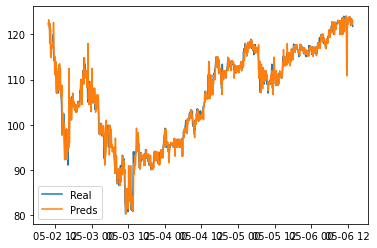

In [26]:
# Decision Tree
dt_results = testModel(data_5min_ta, 360, 9000, 10200, 1, 'dt')


RMSE mean:0.976544255629993, std:1.0551912545762463


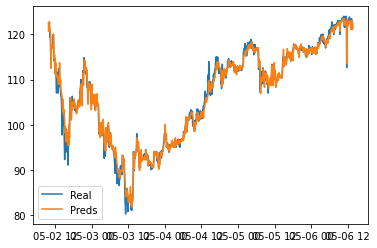

In [27]:
# LGBM
lgbm_results = testModel(data_5min_ta, 360, 9000, 10200, 1, 'lgbm')


RMSE mean:0.9756259522739466, std:1.064806127909745


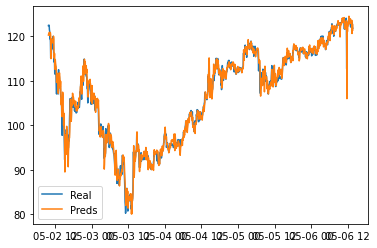

In [30]:
# Linear Regression
lr_results = testModel(data_5min_ta, 360, 9000, 10200, 1, 'lr')


RMSE mean:1.007806593961111, std:1.073035377178316


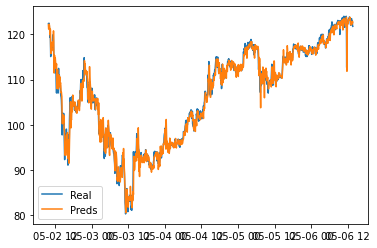

In [31]:
# XGBoost
xgb_results = testModel(data_5min_ta, 360, 9000, 10200, 1, 'xgb')


RMSE mean:8.040499649785465, std:5.634449785913653


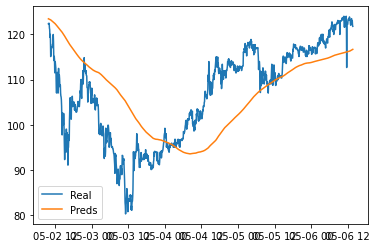

In [33]:
# SVM Regressor
svr_results = testModel(data_5min_ta, 360, 9000, 10200, 1, 'svr')